# Tokens cleaning and topic modelling

In [27]:

import sys
sys.path.append("..")

from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import Dataset
from src.tokenizers import BatchTokenizer
from src.vectorizers import TokenTfidfVectorizer

## Tokens analysis and cleaning

We start by loading the tokens and by plotting the distribution

In [2]:
dataset = Dataset(dataset_path="", save_path=f"../data/processed/tokenized_processed.json")
tokens = dataset.load_text_list(field_name="tokens")

In [49]:
x = [len(x) for x in tokens]

fun = [max, min, np.mean, np.std]

pprint([(f.__name__, f(x)) for f in fun])

[('max', 13621),
 ('min', 0),
 ('mean', 512.8494901371639),
 ('std', 553.5780226880737)]


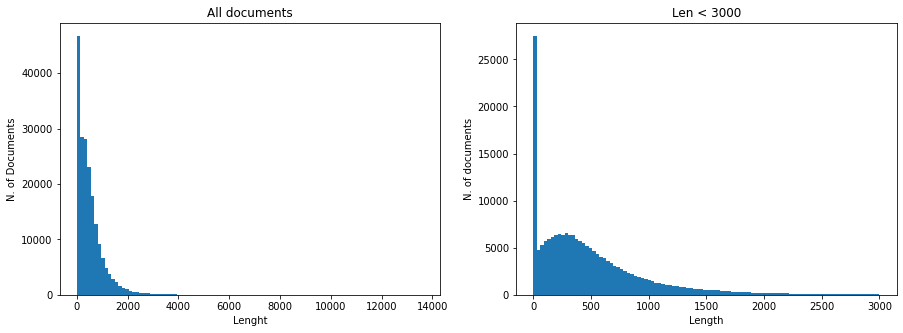

In [78]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(x, bins=100)
axs[1].hist(list(filter(lambda x:x<3000, x)), bins=100)
axs[0].set(title= "All documents", xlabel="Lenght", ylabel="N. of Documents")
axs[1].set(title= "Len < 3000", xlabel="Lenght", ylabel="N. of Documents")

plt.xlabel("Length")
plt.ylabel("N. of documents")
plt.show()

### Cleaning the tokens

In [ ]:
# ...

## Topic modelling

### Vectorization

In [5]:
dv = TokenTfidfVectorizer(tokens)

vectors = dv.vectors()
dv.save_vectors_vectorizer(vectors)

print(f"Vocabulary length: {len(dv.vectorizer.vocabulary_)}")

Vocabulary length: 455470


### Vectors loading
Loading of previusly computed vectors, to avoid recomputing

In [2]:
vectors, vectorizer = TokenTfidfVectorizer.load_vectors_vectorizer()

## Guided LDA model definition

We start by setting the priors, then fit the model.

In [79]:
# ...